In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [4]:
# 1. Import required libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# 2. Load X and y from CSV (if not already loaded)
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# 3. Drop NaNs in y_train (X_train must match the same indices)
y_train_clean = y_train.dropna()
X_train_clean = X_train.loc[y_train_clean.index]

# 4. Apply SMOTE for each label separately and evaluate
for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    # Extract label-specific y
    y_train_label = y_train_clean[label]
    y_test_label = y_test[label]  # y_test may still have all rows

    # SMOTE
    sm = SMOTE(random_state=70)
    X_resampled, y_resampled = sm.fit_resample(X_train_clean, y_train_label)

    # Train XGBoost
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=30)
    model.fit(X_resampled, y_resampled)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation
    print(classification_report(y_test_label, y_pred, digits=4))
    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy: {acc:.4f}")




Training and Evaluating for label: ADHD_Outcome


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.2750    0.2037    0.2340       108
           1     0.6972    0.7734    0.7333       256

    accuracy                         0.6044       364
   macro avg     0.4861    0.4886    0.4837       364
weighted avg     0.5719    0.6044    0.5852       364

Accuracy: 0.6044

Training and Evaluating for label: Sex_F


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.6560    0.7741    0.7102       239
           1     0.3415    0.2240    0.2705       125

    accuracy                         0.5852       364
   macro avg     0.4987    0.4990    0.4904       364
weighted avg     0.5480    0.5852    0.5592       364

Accuracy: 0.5852


In [5]:
from sklearn.metrics import accuracy_score, classification_report

# Collect predictions for all labels
all_preds = []
all_truth = []

# For each label
for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    y_train_label = y_train_clean[label]
    y_test_label = y_test[label]

    # SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train_clean, y_train_label)

    # Train model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_resampled, y_resampled)

    # Predict
    y_pred = model.predict(X_test)

    # Store for combined accuracy
    all_preds.append(y_pred)
    all_truth.append(y_test_label.values)

    # Individual accuracy and report
    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy for {label}: {acc:.4f}")
    print(classification_report(y_test_label, y_pred, digits=4))

# Transpose to get shape (n_samples, n_labels)
y_pred_combined = np.array(all_preds).T
y_true_combined = np.array(all_truth).T

# Combined multi-label accuracy
combined_acc = np.mean(np.all(y_pred_combined == y_true_combined, axis=1))
print("\n==============================")
print(f"🔁 Combined multi-label accuracy: {combined_acc:.4f}")



Training and Evaluating for label: ADHD_Outcome


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy for ADHD_Outcome: 0.6456
              precision    recall  f1-score   support

           0     0.3600    0.2500    0.2951       108
           1     0.7197    0.8125    0.7633       256

    accuracy                         0.6456       364
   macro avg     0.5399    0.5312    0.5292       364
weighted avg     0.6130    0.6456    0.6244       364


Training and Evaluating for label: Sex_F


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy for Sex_F: 0.5632
              precision    recall  f1-score   support

           0     0.6379    0.7741    0.6994       239
           1     0.2703    0.1600    0.2010       125

    accuracy                         0.5632       364
   macro avg     0.4541    0.4670    0.4502       364
weighted avg     0.5117    0.5632    0.5283       364


🔁 Combined multi-label accuracy: 0.3736


In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)  # try 30, 40, or 50
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    # Extract label-specific y
    y_train_label = y_train_clean[label]
    y_test_label = y_test[label]  # y_test may still have all rows

    # SMOTE
    sm = SMOTE(random_state=70)
    X_resampled, y_resampled = sm.fit_resample(X_train_pca, y_train_label)
    mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50, 30,15,5),  # 2 hidden layers
    activation='tanh',
    solver='lbfgs',
    learning_rate='adaptive',
    max_iter=3000,
    random_state=30,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=True
)



# 3. Fit the pipeline
    mlp.fit(X_resampled, y_resampled)
# 4. Predict and evaluate
    y_pred = mlp.predict(X_test_pca)
    print(classification_report(y_test_label, y_pred, digits=4))
    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy: {acc:.4f}")



Training and Evaluating for label: ADHD_Outcome
              precision    recall  f1-score   support

           0     0.2963    0.3704    0.3292       108
           1     0.7031    0.6289    0.6639       256

    accuracy                         0.5522       364
   macro avg     0.4997    0.4996    0.4966       364
weighted avg     0.5824    0.5522    0.5646       364

Accuracy: 0.5522

Training and Evaluating for label: Sex_F
              precision    recall  f1-score   support

           0     0.6901    0.6151    0.6504       239
           1     0.3907    0.4720    0.4275       125

    accuracy                         0.5659       364
   macro avg     0.5404    0.5435    0.5390       364
weighted avg     0.5873    0.5659    0.5739       364

Accuracy: 0.5659


In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Collect predictions for all labels
all_preds = []
all_truth = []

# For each label
for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    y_train_label = y_train_clean[label]
    y_test_label = y_test[label]

    # SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train_pca, y_train_label)

    # Train model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_resampled, y_resampled)

    # Predict
    y_pred = model.predict(X_test_pca)

    # Store for combined accuracy
    all_preds.append(y_pred)
    all_truth.append(y_test_label.values)

    # Individual accuracy and report
    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy for {label}: {acc:.4f}")
    print(classification_report(y_test_label, y_pred, digits=4))

# Transpose to get shape (n_samples, n_labels)
y_pred_combined = np.array(all_preds).T
y_true_combined = np.array(all_truth).T

# Combined multi-label accuracy
combined_acc = np.mean(np.all(y_pred_combined == y_true_combined, axis=1))
print("\n==============================")
print(f"🔁 Combined multi-label accuracy: {combined_acc:.4f}")



Training and Evaluating for label: ADHD_Outcome


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy for ADHD_Outcome: 0.5989
              precision    recall  f1-score   support

           0     0.3623    0.4630    0.4065       108
           1     0.7434    0.6562    0.6971       256

    accuracy                         0.5989       364
   macro avg     0.5528    0.5596    0.5518       364
weighted avg     0.6303    0.5989    0.6109       364


Training and Evaluating for label: Sex_F


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:43:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy for Sex_F: 0.5110
              precision    recall  f1-score   support

           0     0.6517    0.5481    0.5955       239
           1     0.3374    0.4400    0.3819       125

    accuracy                         0.5110       364
   macro avg     0.4946    0.4941    0.4887       364
weighted avg     0.5438    0.5110    0.5221       364


🔁 Combined multi-label accuracy: 0.2830


In [1]:
# === Step 1: Import Required Libraries ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# === Step 2: Load the pre-split datasets ===
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# === Step 3: Clean labels (remove rows with NaNs) ===
X_train_clean = X_train.copy()
y_train_clean = y_train.dropna()
X_train_clean = X_train_clean.loc[y_train_clean.index]

# === Step 4: Train Random Forest per label with SMOTE ===
all_preds = []
all_truth = []

for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    y_train_label = y_train_clean[label]
    y_test_label = y_test[label]

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train_clean, y_train_label)

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_resampled, y_resampled)

    # Predict
    y_pred = rf.predict(X_test)

    # Store predictions and ground truth
    all_preds.append(y_pred)
    all_truth.append(y_test_label.values)

    # Individual label performance
    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy for {label}: {acc:.4f}")
    print(classification_report(y_test_label, y_pred, digits=4))

# === Step 5: Compute Combined Multi-label Accuracy ===
y_pred_combined = np.array(all_preds).T
y_true_combined = np.array(all_truth).T
combined_acc = np.mean(np.all(y_pred_combined == y_true_combined, axis=1))
print("\n==============================")
print(f"🔁 Combined multi-label accuracy (exact match): {combined_acc:.4f}")



Training and Evaluating for label: ADHD_Outcome
Accuracy for ADHD_Outcome: 0.6978
              precision    recall  f1-score   support

           0     0.4500    0.0833    0.1406       108
           1     0.7122    0.9570    0.8167       256

    accuracy                         0.6978       364
   macro avg     0.5811    0.5202    0.4786       364
weighted avg     0.6344    0.6978    0.6161       364


Training and Evaluating for label: Sex_F
Accuracy for Sex_F: 0.6071
              precision    recall  f1-score   support

           0     0.6412    0.9121    0.7530       239
           1     0.1250    0.0240    0.0403       125

    accuracy                         0.6071       364
   macro avg     0.3831    0.4681    0.3966       364
weighted avg     0.4639    0.6071    0.5083       364


🔁 Combined multi-label accuracy (exact match): 0.4451


In [6]:
# Step 1: Imports
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 2: Load the CSVs
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Step 3: Drop rows with NaNs in y_train and align X_train
y_train_clean = y_train.dropna()
X_train_clean = X_train.loc[y_train_clean.index]

# Step 4: Standardize (just in case)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define the neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train_clean.shape[1], activation='sigmoid')  # one output per label
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train
history = model.fit(
    X_train_scaled, 
    y_train_clean, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)

# Step 7: Predict
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Step 8: Evaluation
for i, column in enumerate(y_test.columns):
    print(f"\nLabel: {column}")
    print(classification_report(y_test[column], y_pred[:, i], digits=4))
    acc = accuracy_score(y_test[column], y_pred[:, i])
    print(f"Accuracy: {acc:.4f}")

# Step 9: Combined Multi-label Accuracy (exact match)
combined_acc = np.mean(np.all(y_pred == y_test.values, axis=1))
print("\n==============================")
print(f"🔁 Combined multi-label accuracy (exact match): {combined_acc:.4f}")


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7617 - loss: 0.7787 - val_accuracy: 0.7588 - val_loss: 0.7239
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8137 - loss: 0.5424 - val_accuracy: 0.7412 - val_loss: 0.7042
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8601 - loss: 0.4651 - val_accuracy: 0.7529 - val_loss: 0.7113
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8762 - loss: 0.3576 - val_accuracy: 0.6941 - val_loss: 0.7362
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8471 - loss: 0.2691 - val_accuracy: 0.7412 - val_loss: 0.7993
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8681 - loss: 0.2136 - val_accuracy: 0.7353 - val_loss: 0.8716
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.1318 - val_accuracy: 0.7118 - val_loss: 0.9472
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8204 - loss: 0.1198 - val_accuracy: 0.7471 - val_loss

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# === Step 4: Train KNN per label with SMOTE and hyperparameter tuning ===
all_preds = []
all_truth = []

param_grid = {'n_neighbors': [3, 5, 7, 9]}  # Values to try

for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    y_train_label = y_train_clean[label].astype(int)
    y_test_label = y_test[label]

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train_clean, y_train_label)

    # Optional: Print class balance after SMOTE
    print(f"After SMOTE - label counts: {np.bincount(y_resampled)}")

    # KNN + GridSearchCV
    knn = KNeighborsClassifier(n_jobs=-1)
    grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)

    best_k = grid_search.best_params_['n_neighbors']
    print(f"Best n_neighbors for {label}: {best_k}")

    # Train best KNN model
    best_knn = grid_search.best_estimator_

    # Predict
    y_pred = best_knn.predict(X_test)

    # Store predictions and ground truth
    all_preds.append(y_pred)
    all_truth.append(y_test_label.values)

    # Individual label performance
    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy for {label}: {acc:.4f}")
    print(classification_report(y_test_label, y_pred, digits=4))



Training and Evaluating for label: ADHD_Outcome
After SMOTE - label counts: [575 575]
Best n_neighbors for ADHD_Outcome: 3
Accuracy for ADHD_Outcome: 0.2967
              precision    recall  f1-score   support

           0     0.2944    0.9815    0.4530       108
           1     0.5000    0.0078    0.0154       256

    accuracy                         0.2967       364
   macro avg     0.3972    0.4946    0.2342       364
weighted avg     0.4390    0.2967    0.1452       364


Training and Evaluating for label: Sex_F
After SMOTE - label counts: [558 558]
Best n_neighbors for Sex_F: 3
Accuracy for Sex_F: 0.3462
              precision    recall  f1-score   support

           0     0.5714    0.0167    0.0325       239
           1     0.3417    0.9760    0.5062       125

    accuracy                         0.3462       364
   macro avg     0.4566    0.4964    0.2694       364
weighted avg     0.4926    0.3462    0.1952       364



In [9]:
y_pred_combined = np.array(all_preds).T
y_true_combined = np.array(all_truth).T
combined_acc = np.mean(np.all(y_pred_combined == y_true_combined, axis=1))
print("\n==============================")
print(f"🔁 Combined multi-label accuracy (exact match): {combined_acc:.4f}")



🔁 Combined multi-label accuracy (exact match): 0.1346


In [14]:
# === Step 1: Import Required Libraries ===
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# === Step 2: Load the pre-split datasets ===
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# === Step 3: Clean labels (remove rows with NaNs) ===
y_train_clean = y_train.dropna()
X_train_clean = X_train.loc[y_train_clean.index]

# === Step 4: Scale the features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

# === Step 5: Train Logistic Regression per label ===
all_preds = []
all_truth = []

for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    y_train_label = y_train_clean[label].astype(int)
    y_test_label = y_test[label]

    # Train Logistic Regression with class_weight='balanced'
    lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=25)
    lr.fit(X_train_scaled, y_train_label)

    # Predict
    y_pred = lr.predict(X_test_scaled)

    # Store predictions and ground truth
    all_preds.append(y_pred)
    all_truth.append(y_test_label.values)

    # Individual label performance
    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy for {label}: {acc:.4f}")
    print(classification_report(y_test_label, y_pred, digits=4))

# === Step 6: Compute Combined Multi-label Accuracy ===
y_pred_combined = np.array(all_preds).T
y_true_combined = np.array(all_truth).T
combined_acc = np.mean(np.all(y_pred_combined == y_true_combined, axis=1))

print("\n==============================")
print(f"🔁 Combined multi-label accuracy (exact match): {combined_acc:.4f}")



Training and Evaluating for label: ADHD_Outcome
Accuracy for ADHD_Outcome: 0.5247
              precision    recall  f1-score   support

           0     0.2789    0.3796    0.3216       108
           1     0.6912    0.5859    0.6342       256

    accuracy                         0.5247       364
   macro avg     0.4851    0.4828    0.4779       364
weighted avg     0.5689    0.5247    0.5415       364


Training and Evaluating for label: Sex_F
Accuracy for Sex_F: 0.5220
              precision    recall  f1-score   support

           0     0.6444    0.6067    0.6250       239
           1     0.3237    0.3600    0.3409       125

    accuracy                         0.5220       364
   macro avg     0.4841    0.4833    0.4830       364
weighted avg     0.5343    0.5220    0.5274       364


🔁 Combined multi-label accuracy (exact match): 0.2692



Feature selection for label: ADHD_Outcome
🔍 Top 10 features contributing to ADHD_Outcome:
PC150    1.330548
PC68     1.277009
PC191    1.178236
PC244    1.161501
PC427    1.087038
PC52     1.077052
PC108    1.062642
PC463    1.021697
PC444    0.994545
PC23     0.990333
dtype: float64


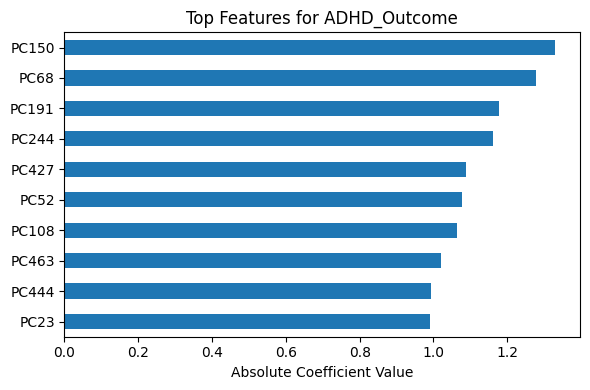

✅ Selected 264 features out of 528 for ADHD_Outcome
Selected features: ['PC1', 'PC4', 'PC5', 'PC6', 'PC7', 'PC14', 'PC15', 'PC17', 'PC20', 'PC21', 'PC22', 'PC23', 'PC26', 'PC27', 'PC28', 'PC30', 'PC31', 'PC32', 'PC33', 'PC36', 'PC37', 'PC42', 'PC44', 'PC45', 'PC48', 'PC49', 'PC52', 'PC54', 'PC55', 'PC56', 'PC57', 'PC58', 'PC59', 'PC61', 'PC65', 'PC68', 'PC69', 'PC70', 'PC73', 'PC74', 'PC75', 'PC77', 'PC78', 'PC79', 'PC80', 'PC82', 'PC88', 'PC90', 'PC91', 'PC92', 'PC93', 'PC94', 'PC95', 'PC97', 'PC101', 'PC104', 'PC106', 'PC108', 'PC109', 'PC114', 'PC115', 'PC122', 'PC123', 'PC126', 'PC127', 'PC128', 'PC129', 'PC130', 'PC131', 'PC135', 'PC137', 'PC139', 'PC141', 'PC142', 'PC143', 'PC145', 'PC146', 'PC147', 'PC149', 'PC150', 'PC154', 'PC160', 'PC161', 'PC162', 'PC164', 'PC165', 'PC167', 'PC169', 'PC170', 'PC172', 'PC173', 'PC175', 'PC178', 'PC181', 'PC184', 'PC187', 'PC190', 'PC191', 'PC192', 'PC193', 'PC195', 'PC196', 'PC197', 'PC198', 'PC200', 'PC203', 'PC206', 'PC210', 'PC213', 'PC214

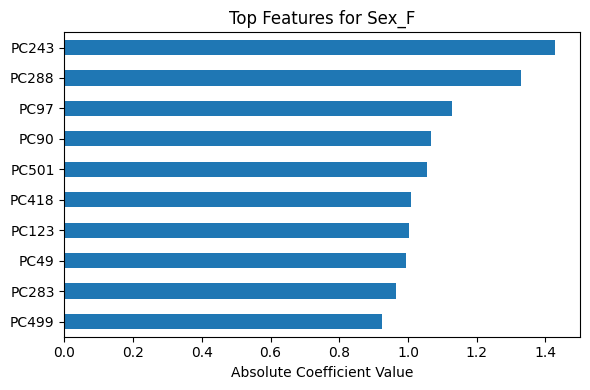

✅ Selected 264 features out of 528 for Sex_F
Selected features: ['PC1', 'PC2', 'PC6', 'PC10', 'PC11', 'PC14', 'PC15', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC24', 'PC28', 'PC29', 'PC31', 'PC33', 'PC35', 'PC36', 'PC39', 'PC41', 'PC43', 'PC46', 'PC47', 'PC48', 'PC49', 'PC51', 'PC53', 'PC59', 'PC61', 'PC62', 'PC63', 'PC64', 'PC66', 'PC69', 'PC71', 'PC74', 'PC77', 'PC78', 'PC79', 'PC80', 'PC81', 'PC83', 'PC86', 'PC89', 'PC90', 'PC92', 'PC96', 'PC97', 'PC99', 'PC102', 'PC104', 'PC105', 'PC106', 'PC107', 'PC108', 'PC110', 'PC111', 'PC113', 'PC114', 'PC115', 'PC116', 'PC117', 'PC121', 'PC123', 'PC124', 'PC125', 'PC126', 'PC130', 'PC132', 'PC133', 'PC136', 'PC137', 'PC139', 'PC140', 'PC143', 'PC147', 'PC148', 'PC150', 'PC151', 'PC153', 'PC156', 'PC159', 'PC160', 'PC161', 'PC162', 'PC164', 'PC165', 'PC168', 'PC170', 'PC171', 'PC173', 'PC174', 'PC175', 'PC176', 'PC179', 'PC180', 'PC181', 'PC182', 'PC185', 'PC186', 'PC187', 'PC188', 'PC189', 'PC192', 'PC193', 'PC195', 'PC197', 'PC199', 'PC200'

In [3]:
# === Step 1: Import Required Libraries ===
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# === Step 2: Load the pre-split datasets ===
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# === Step 3: Clean labels (remove rows with NaNs) ===
y_train_clean = y_train.dropna()
X_train_clean = X_train.loc[y_train_clean.index]
feature_names = X_train.columns

# === Step 4: Scale the features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

# === Step 5: Feature Selection per label ===
selected_features_sets = []  # store selected features per label

for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Feature selection for label: {label}")

    y_train_label = y_train_clean[label].astype(int)

    # Train Logistic Regression
    base_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    base_lr.fit(X_train_scaled, y_train_label)

    # Feature importance
    coef = base_lr.coef_[0]
    feature_importance = pd.Series(np.abs(coef), index=feature_names)
    top_features = feature_importance.sort_values(ascending=False).head(10)

    print(f"🔍 Top 10 features contributing to {label}:")
    print(top_features)

    # Plot top features
    top_features.sort_values().plot(kind='barh', figsize=(6,4), title=f"Top Features for {label}")
    plt.xlabel("Absolute Coefficient Value")
    plt.tight_layout()
    plt.show()

    # Automatic feature selection (keep features above median)
    selector = SelectFromModel(base_lr, threshold='median', prefit=True)
    selected_mask = selector.get_support()
    selected_features = feature_names[selected_mask]
    print(f"✅ Selected {len(selected_features)} features out of {len(feature_names)} for {label}")
    print(f"Selected features: {list(selected_features)}")

    selected_features_sets.append(set(selected_features))

# === Step 6: Compute Union of Selected Features ===
common_selected_features = set.union(*selected_features_sets)
print("\n==============================")
print(f"🛠️ Union of selected features across all labels: {len(common_selected_features)} features")
print(sorted(common_selected_features))

# Reduce dataset ONCE
X_train_reduced = X_train_clean[list(common_selected_features)]
X_test_reduced = X_test[list(common_selected_features)]


# === Step 7: Train Logistic Regression per label (on common reduced features) ===
all_preds = []
all_truth = []

for label in y_train_clean.columns:
    print(f"\n==============================")
    print(f"Training and Evaluating for label: {label}")

    y_train_label = y_train_clean[label].astype(int)
    y_test_label = y_test[label]

    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr.fit(X_train_reduced, y_train_label)

    y_pred = lr.predict(X_test_reduced)

    all_preds.append(y_pred)
    all_truth.append(y_test_label.values)

    acc = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy for {label}: {acc:.4f}")
    print(classification_report(y_test_label, y_pred, digits=4))

# === Step 8: Compute Combined Multi-label Accuracy ===
y_pred_combined = np.array(all_preds).T
y_true_combined = np.array(all_truth).T
combined_acc = np.mean(np.all(y_pred_combined == y_true_combined, axis=1))

print("\n==============================")
print(f"🔁 Combined multi-label accuracy (exact match): {combined_acc:.4f}")


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for Decision Tree
param_grid = {
    'estimator__max_depth': [3, 5,7, 10, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__criterion': ['gini', 'entropy']
}

# Create base Decision Tree model
dt = DecisionTreeClassifier(random_state=30)

# Wrap in MultiOutputClassifier
multi_clf = MultiOutputClassifier(dt)

# Apply GridSearchCV
grid_search = GridSearchCV(multi_clf, param_grid, cv=6, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_clean, y_train_clean)

# Get best estimator
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate for each label
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y_test.columns))

# Combined accuracy (average of individual accuracies)
acc_adhd = accuracy_score(y_test['ADHD_Outcome'], y_pred[:, 0])
acc_sex = accuracy_score(y_test['Sex_F'], y_pred[:, 1])

print(f"\nAccuracy ADHD_Outcome: {acc_adhd:.4f}")
print(f"Accuracy Sex_F: {acc_sex:.4f}")



Classification Report:
              precision    recall  f1-score   support

ADHD_Outcome       0.69      0.86      0.77       256
       Sex_F       0.53      0.07      0.13       125

   micro avg       0.68      0.60      0.64       381
   macro avg       0.61      0.47      0.45       381
weighted avg       0.64      0.60      0.56       381
 samples avg       0.61      0.54      0.56       381


Accuracy ADHD_Outcome: 0.6346
Accuracy Sex_F: 0.6593


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
for i, column in enumerate(y_test.columns):
    print(f"Classification report for label: {column}")
    print(classification_report(y_test[column], y_pred[:, i]))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification report for label: ADHD_Outcome
              precision    recall  f1-score   support

           0       0.22      0.09      0.13       108
           1       0.69      0.86      0.77       256

    accuracy                           0.63       364
   macro avg       0.46      0.48      0.45       364
weighted avg       0.55      0.63      0.58       364

Classification report for label: Sex_F
              precision    recall  f1-score   support

           0       0.67      0.97      0.79       239
           1       0.53      0.07      0.13       125

    accuracy                           0.66       364
   macro avg       0.60      0.52      0.46       364
weighted avg       0.62      0.66      0.56       364

Accuracy: 0.44505494505494503
